## Course Assignment Instructions
You should have Python (version 3.8 or later) and Jupyter Notebook installed to complete this assignment. You will write code in the empty cell/cells below the problem. While most of this will be a programming assignment, some questions will ask you to "write a few sentences" in markdown cells. 

Submission Instructions:

Create a labs directory in your personal class repository (e.g., located in your home directory)
Clone the class repository
Copy this Jupyter notebook file (.ipynb) into your repo/labs directory
Make your edits, commit changes, and push to your repository
All submissions must be pushed before the due date to avoid late penalties. 

Labs are graded out of a 100 pts. Each day late is -10. For a max penalty of -50 after 5 days. From there you may submit the lab anytime before the semester ends for a max score of 50.  


## Boosting

We will now write a gradient boosting algorithm from scratch. We will make it as general as possible for regression and classification and we will make use of sci-kit learn's DecisionTreeRegressor

In [4]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from plotnine import ggplot, aes, geom_line, geom_point, labs, ggtitle, theme_light


#Define the sigmoid function.
def sigmoid(x):
    """Standard sigmoid function to map scores to probabilities."""
    return 1 / (1 + np.exp(-x))

class GradientBoosting:
    def __init__(self, is_classification=False, base_learner=None, neg_gradient=None, M=None, eta=0.3, verbose=True):
        """
        Initializes the gradient boosting model.
        
        Parameters:
          is_classification (bool): Whether the problem is binary classification.
          base_learner (estimator): A base learner instance (default: DecisionTreeRegressor with min_samples_leaf=10%).
          neg_gradient (function): Function to compute negative gradient.
          M (int): Number of boosting iterations (default: 50 for regression, 100 for classification).
          eta (float): Learning rate.
          verbose (bool): Whether to print progress messages.
        """
        self.is_classification = is_classification
        self.M = M if M is not None else (100 if is_classification else 50)
        self.eta = eta
        self.verbose = verbose
        self.base_learner = base_learner
        self.neg_gradient = neg_gradient
        self.base_learners = []
        self.init_val = None  # Initial prediction value
        
    def fit(self, X, y):
        """
        Fit the gradient boosting model.
        
        Parameters:
          X (array-like): Feature matrix (n_samples x n_features).
          y (array-like): Target vector.
        """
        n = X.shape[0]
        
        #Set default base learner if none provided.
        if self.base_learner is None:
            #Use a regression tree with min_samples_leaf as 10% of n.
            self.base_learner = DecisionTreeRegressor(min_samples_leaf=max(1, int(0.1 * n)))
        
        #Set default negative gradient function if not provided.
        if self.neg_gradient is None:
            if self.is_classification:
                #For binary classification, negative gradient for log-odds is y - sigmoid(f)
                self.neg_gradient = lambda y, f: y - sigmoid(f)
            else:
                #For regression, derivative of squared error
                self.neg_gradient = lambda y, f: 2 * (y - f)
        
        #Initial prediction:
        if self.is_classification:
            #For binary classification, start with a log-odds prediction based on the mean response.
            p = np.mean(y)
            p = np.clip(p, 1e-5, 1 - 1e-5)  #avoid extreme probabilities
            self.init_val = np.log(p / (1 - p))
        else:
            #For regression, start with the mean of y.
            self.init_val = np.mean(y)
            
        #Initialize the prediction array f.
        f = np.full(n, self.init_val, dtype=np.float64)
        self.train_predictions = [f.copy()]  # record predictions per iteration
        
        #Boosting iterations:
        for m in range(self.M):
            #Compute the negative gradient.
            neg_grad = self.neg_gradient(y, f)
            
            #Fit a new base learner to the negative gradient.
            tree = clone(self.base_learner)
            tree.fit(X, neg_grad)
            
            #Predict the adjustments from this base learner.
            h = tree.predict(X)
            #Update the overall prediction.
            f += self.eta * h
            self.base_learners.append(tree)
            self.train_predictions.append(f.copy())
            
            #Display training progress.
            if self.verbose:
                if self.is_classification:
                    preds = (sigmoid(f) > 0.5).astype(int)
                    error = np.mean(preds != y)
                    print(f"Iteration {m+1}/{self.M}, training error: {error:.4f}")
                else:
                    rmse = np.sqrt(np.mean((y - f) ** 2))
                    print(f"Iteration {m+1}/{self.M}, RMSE: {rmse:.4f}")
        self.final_prediction = f
        return self
    
    def predict(self, X):
        """
        Returns final predictions.
        
        For regression, returns the predicted numeric values.
        For classification, returns class labels (0 or 1).
        """
        n = X.shape[0]
        f = np.full(n, self.init_val, dtype=np.float64)
        for tree in self.base_learners:
            f += self.eta * tree.predict(X)
        if self.is_classification:
            return (sigmoid(f) > 0.5).astype(int)
        else:
            return f
        
    def predict_proba(self, X):
        """
        Returns probability estimates for the positive class (only for classification).
        """
        if not self.is_classification:
            raise ValueError("predict_proba is only available for classification models")
        n = X.shape[0]
        f = np.full(n, self.init_val, dtype=np.float64)
        for tree in self.base_learners:
            f += self.eta * tree.predict(X)
        return sigmoid(f)

Now we test the code in-sample: Create an example for Regression.

Iteration 1/50, RMSE: 1.1755
Iteration 2/50, RMSE: 0.9824
Iteration 3/50, RMSE: 0.9151
Iteration 4/50, RMSE: 0.8275
Iteration 5/50, RMSE: 0.7923
Iteration 6/50, RMSE: 0.7567
Iteration 7/50, RMSE: 0.7205
Iteration 8/50, RMSE: 0.6946
Iteration 9/50, RMSE: 0.6661
Iteration 10/50, RMSE: 0.6403
Iteration 11/50, RMSE: 0.6157
Iteration 12/50, RMSE: 0.5883
Iteration 13/50, RMSE: 0.5669
Iteration 14/50, RMSE: 0.5410
Iteration 15/50, RMSE: 0.5218
Iteration 16/50, RMSE: 0.4995
Iteration 17/50, RMSE: 0.4813
Iteration 18/50, RMSE: 0.4606
Iteration 19/50, RMSE: 0.4510
Iteration 20/50, RMSE: 0.4338
Iteration 21/50, RMSE: 0.4174
Iteration 22/50, RMSE: 0.4027
Iteration 23/50, RMSE: 0.3911
Iteration 24/50, RMSE: 0.3797
Iteration 25/50, RMSE: 0.3709
Iteration 26/50, RMSE: 0.3612
Iteration 27/50, RMSE: 0.3498
Iteration 28/50, RMSE: 0.3400
Iteration 29/50, RMSE: 0.3285
Iteration 30/50, RMSE: 0.3182
Iteration 31/50, RMSE: 0.3098
Iteration 32/50, RMSE: 0.2976
Iteration 33/50, RMSE: 0.2893
Iteration 34/50, RM

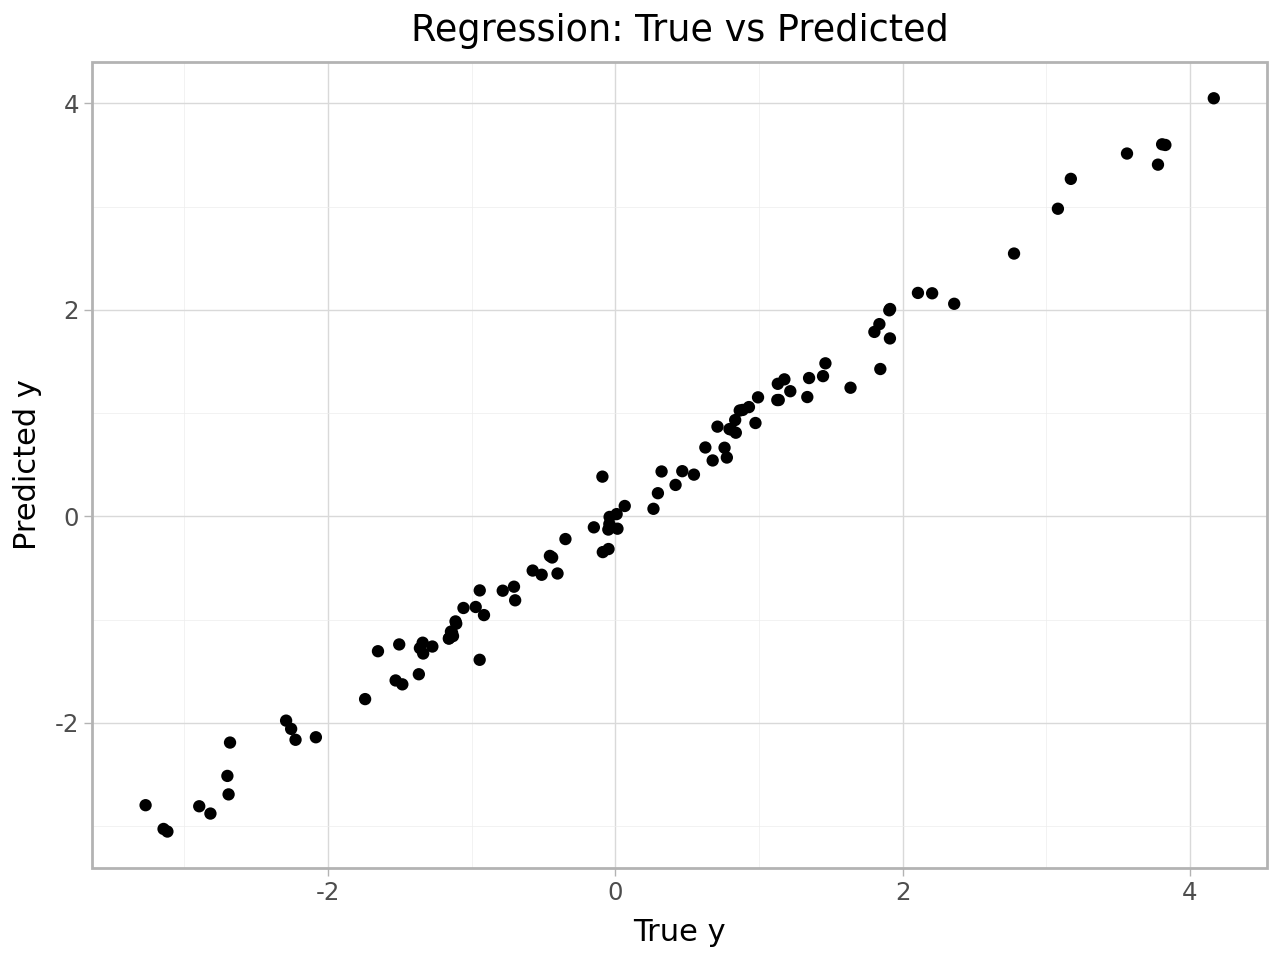

In [21]:
#Regression Example
np.random.seed(1)
n_samples = 100
n_features = 3

#Generate a random feature matrix and true coefficients.
X_reg = np.random.randn(n_samples, n_features)
beta = np.linspace(-1, 1, n_features)

#Create a regression target with additive noise.
y_reg = X_reg.dot(beta) + np.random.randn(n_samples)

#Initialize and fit the gradient boosting model for regression.
model_reg = GradientBoosting(is_classification = False, verbose = True)
model_reg.fit(X_reg, y_reg)

#Obtain predictions.
y_reg_pred = model_reg.predict(X_reg)

#Create a DataFrame for plotting using plotnine.
df_reg = pd.DataFrame({'True_y': y_reg, 'Predicted_y': y_reg_pred})

#Plot using plotnine.
plot_reg = (ggplot(df_reg, aes(x='True_y', y='Predicted_y')) +
            geom_point() +
            labs(x='True y', y='Predicted y') +
            ggtitle('Regression: True vs Predicted') +
            theme_light())
plot_reg

Now let's do this for Classification ... 

In [22]:
#Classification Example
np.random.seed(1)
X_clf = np.random.randn(n_samples, n_features)

#Compute logits and convert to probabilities.
logits = X_clf.dot(beta)
probs = sigmoid(logits)

#Simulate binary outcomes.
y_clf = (np.random.rand(n_samples) < probs).astype(int)

#Initialize and fit the gradient boosting model for classification.
model_clf = GradientBoosting(is_classification = True, verbose = True)
model_clf.fit(X_clf, y_clf)


y_clf_pred = model_clf.predict(X_clf)

#Display a simple confusion matrix.
confusion = pd.crosstab(pd.Series(y_clf, name="Actual"), pd.Series(y_clf_pred, name="Predicted"))
print("Confusion Matrix:\n", confusion)

Iteration 1/100, training error: 0.4400
Iteration 2/100, training error: 0.3700
Iteration 3/100, training error: 0.2900
Iteration 4/100, training error: 0.2600
Iteration 5/100, training error: 0.2600
Iteration 6/100, training error: 0.2600
Iteration 7/100, training error: 0.2600
Iteration 8/100, training error: 0.2600
Iteration 9/100, training error: 0.2000
Iteration 10/100, training error: 0.2100
Iteration 11/100, training error: 0.1800
Iteration 12/100, training error: 0.1900
Iteration 13/100, training error: 0.1900
Iteration 14/100, training error: 0.1800
Iteration 15/100, training error: 0.1800
Iteration 16/100, training error: 0.1800
Iteration 17/100, training error: 0.1800
Iteration 18/100, training error: 0.1800
Iteration 19/100, training error: 0.1800
Iteration 20/100, training error: 0.1700
Iteration 21/100, training error: 0.1700
Iteration 22/100, training error: 0.1500
Iteration 23/100, training error: 0.1700
Iteration 24/100, training error: 0.1500
Iteration 25/100, trainin

Using the diamonds dataset split the data into a training, validation, and test set

In [23]:
import seaborn as sns
from sklearn.model_selection import train_test_split

#Load the diamonds dataset.
diamonds = sns.load_dataset("diamonds")

#Convert categorical variables into dummy/indicator variables.
diamonds_dummies = pd.get_dummies(diamonds, drop_first=True)

#Assume 'price' is the response and split the data:
train_data, temp_data = train_test_split(diamonds_dummies, train_size = 2000, random_state = 1)
validation_data, test_data = train_test_split(temp_data, train_size = 2000, random_state = 1)

#Extract features and response.
X_train = train_data.drop('price', axis = 1).values
y_train = train_data['price'].values

X_validation = validation_data.drop('price', axis = 1).values
y_validation = validation_data['price'].values

X_test = test_data
y_test = test_data

print("Training set size:", X_train.shape )
print("Validation set size:", X_validation.shape )
print("Test set size:", X_test.shape)

Training set size: (2000, 23)
Validation set size: (2000, 23)
Test set size: (49940, 24)


Using your new gradient boosting function, optimize the number of base learners, M for the diamonds data using a grid search:

In [24]:
import numpy as np

M_grid = [10, 20, 30 , 40, 50, 60 ,70 ,80 ,90 , 100]
rmse_list = []

for M_val in M_grid:
    print(f"\nFitting model with M = {M_val}")
    model = GradientBoosting(is_classification = False, verbose = False, M = M_val)
    model.fit(X_train, y_train)
    
    #Predict on the validation set.
    y_pred_val = model_predict(X_validation)
    
    #Compute RMSE.
    rmse = np.sqrt(np.mean((y_validation - y_pred_val)**2))
    rmse_list.append(rmse)
    print(f"M = {M_val}, Validation RMSE = {rmse:.4f}")

#Create a DataFrame with the results.
results_df = pd.DataFrame({'M': M_grid, 'RMSE': rmse_list})
print("\nGrid Search Results:")
print(results_df)

#Identify the best M value (with the lowest RMSE).
best_row = results_df.loc[results_df['RMSE'].idxmin()]
best_M = best_row['M']
best_RMSE = best_row['RMSE']
print(f"\nBest M: {best_M} with RMSE: {best_RMSE:.4f}")

plot = (ggplot(results_df, aes(x='M', y='RMSE')) +
        geom_line() +
        geom_point() +
        labs(x="Number of Base Learners (M)", y="Validation RMSE") +
        ggtitle("Grid Search for Optimal M") +
        theme_light())

plot


Fitting model with M = 10


NameError: name 'model_predict' is not defined

Now find the error in the test set and comment on its performance:

In [25]:
#Train the final model using the best M from grid search.
print(f"\nTraining final model with best_M = {best_M}")
final_model = GradientBoosting(is_classfication = False, verbose = True, M = int(best_M))
final_model.fit(X_train, y_train)

#Predict diamond prices on the test set.
y_test_pred = final_model.predict(X_test)

#Compute the test RMSE.
test_rmse = np.sqrt(np.mean((y_test - y_test_pred)) ** 2))
print(f"\nTest RMSE: {test_rmse:.4f}")

#Create a DataFrame for the test set to use with plotnine.
df_test = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_test_pred
})

#Plot Actual vs Predicted Prices on the test set using plotnine.
test_plot = (ggplot(df_test, aes(x='Actual Price', y='Predicted Price')) +
             geom_point() +
             labs(x='Actual Price', y='Predicted Price') +
             ggtitle('Test Set: Actual vs Predicted Prices') +
             theme_light())
test_plot

SyntaxError: unmatched ')' (1131146910.py, line 10)

The test RMSE printed above indicates the average error in predicting diamond prices on unseen data. A lower RMSE suggests that the model's predictions are close to the actual values. If the test RMSE is comparable to the validation RMSE from the grid search, it implies that the model generalizes well to new data.

On the other hand, if the test RMSE is significantly higher, it may be a sign that the model is overfitting to the training data, and further tuning or model improvements might be necessary.

Now we will assess our custom function performance against the XGBoost package in python. Uncomment the cell below to install xgboost and then run the following cell 

In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



Training XGBoost with n_estimators = 10
n_estimators = 10, Validation RMSE = 872.9022

Training XGBoost with n_estimators = 20
n_estimators = 20, Validation RMSE = 783.2971

Training XGBoost with n_estimators = 30
n_estimators = 30, Validation RMSE = 762.1462

Training XGBoost with n_estimators = 40
n_estimators = 40, Validation RMSE = 763.4311

Training XGBoost with n_estimators = 50
n_estimators = 50, Validation RMSE = 764.6404

Training XGBoost with n_estimators = 60
n_estimators = 60, Validation RMSE = 764.7502

Training XGBoost with n_estimators = 70
n_estimators = 70, Validation RMSE = 762.1247

Training XGBoost with n_estimators = 80
n_estimators = 80, Validation RMSE = 761.8748

Training XGBoost with n_estimators = 90
n_estimators = 90, Validation RMSE = 763.6389

Training XGBoost with n_estimators = 100
n_estimators = 100, Validation RMSE = 763.7491

Grid Search Results:
     M        RMSE
0   10  872.902200
1   20  783.297118
2   30  762.146229
3   40  763.431071
4   50  764

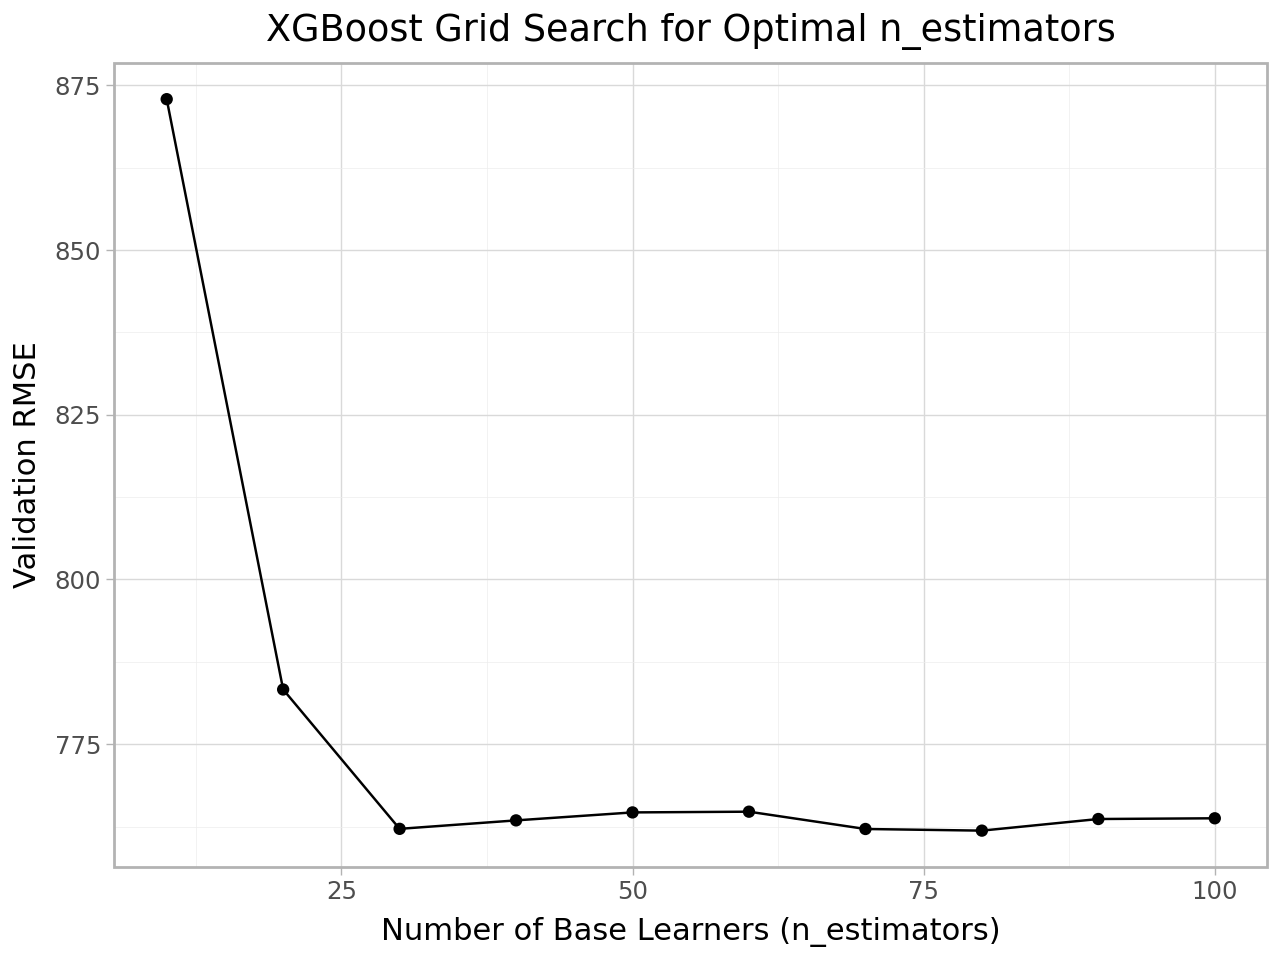

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Split the dataset into training, validation, and test set, we will use 2000 samples for training, 2000 for validation, and the rest as test.
train_data, temp_data = train_test_split(diamonds_dummies, train_size=2000, random_state=1)
validation_data, test_data = train_test_split(temp_data, train_size=2000, random_state=1)

#Separate features and the target (price)
X_train = train_data.drop("price", axis=1)
y_train = train_data["price"]

X_val = validation_data.drop("price", axis=1)
y_val = validation_data["price"]

X_test = test_data.drop("price", axis=1)
y_test = test_data["price"]


#Grid search over n_estimators (M) for XGBoost using training and validation sets
M_grid = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rmse_list = []

for M_val in M_grid:
    print(f"\nTraining XGBoost with n_estimators = {M_val}")
    model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = M_val, learning_rate = 0.3, random_state = 1)
    model.fit(X_train, y_train)
    
    #Predict on the validation set
    y_val_pred = model.predict(X_val)
    
    #Compute RMSE on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_list.append(rmse)
    print(f"n_estimators = {M_val}, Validation RMSE = {rmse:.4f}")

#Create a DataFrame for the grid search results.
results_df = pd.DataFrame({'M': M_grid, 'RMSE': rmse_list})
print("\nGrid Search Results:")
print(results_df)

#Identify the best M value (the n_estimators with the lowest validation RMSE)
best_row = results_df.loc[results_df['RMSE'].idxmin()]
best_M = int(best_row['M'])
best_RMSE = best_row['RMSE']
print(f"\nBest n_estimators (M): {best_M} with Validation RMSE: {best_RMSE:.4f}")

#Plot the grid search results using plotnine.
plot_grid = (ggplot(results_df, aes(x='M', y='RMSE')) +
             geom_line() +
             geom_point() +
             labs(x="Number of Base Learners (n_estimators)", y="Validation RMSE") +
             ggtitle("XGBoost Grid Search for Optimal n_estimators") +
             theme_light())
plot_grid


Final XGBoost Test RMSE: 789.1922


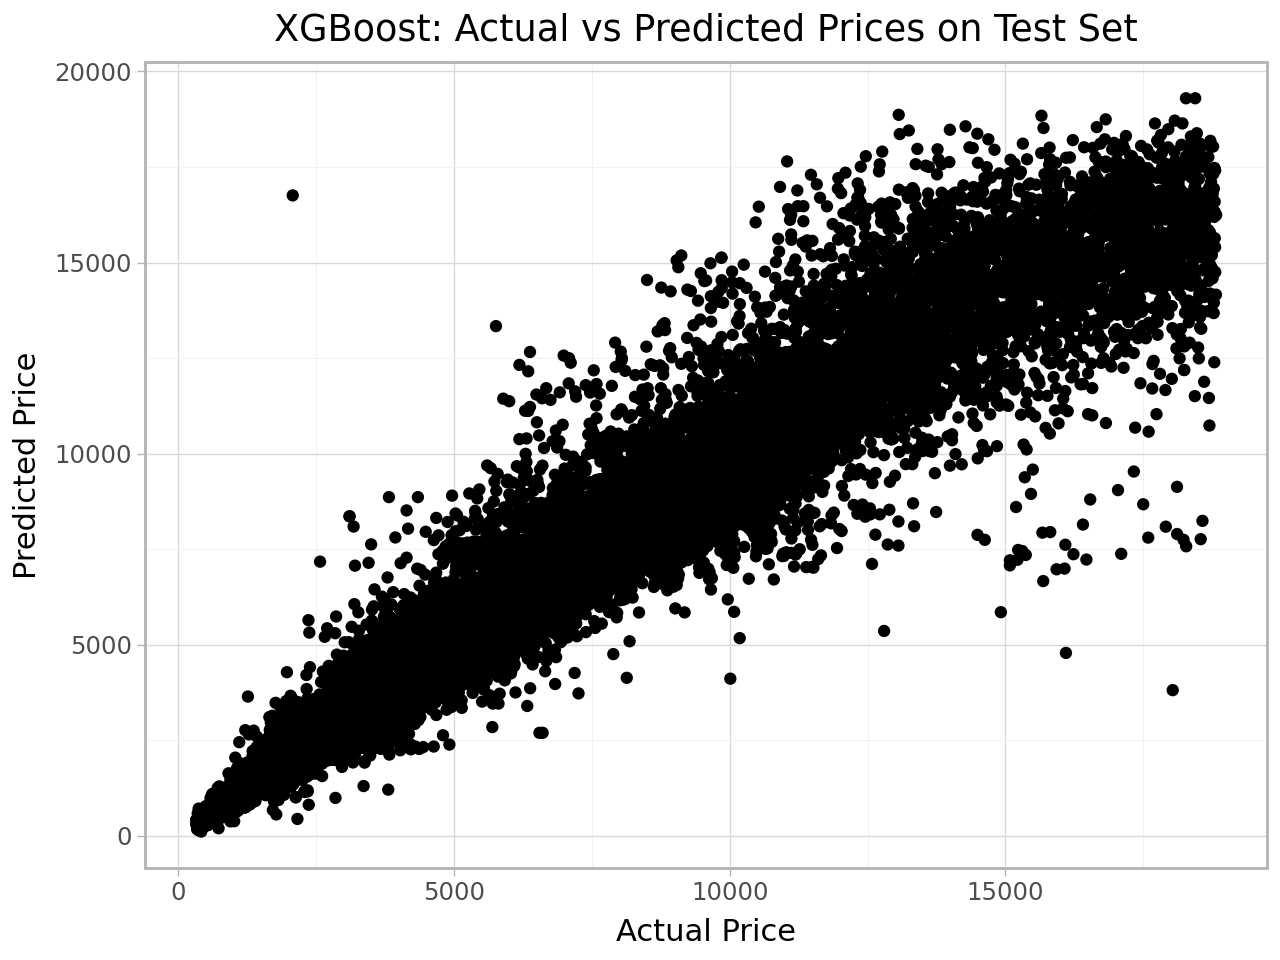

In [12]:
#Train the final XGBoost model using the best M on combined training and validation sets 
#Combine training and validation sets to make the most out of available data.
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

final_model = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = M_val, learning_rate = 0.3, random_state = 1 )
final_model.fit(X_train_val, y_train_val)

#Evaluate the final model on the test set
y_test_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nFinal XGBoost Test RMSE: {test_rmse:.4f}")

#Plot Actual vs Predicted Prices on the test set using plotnine.
df_test = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_test_pred
})

plot_test = (ggplot(df_test, aes(x='Actual Price', y='Predicted Price')) +
             geom_point() +
             labs(x='Actual Price', y='Predicted Price') +
             ggtitle('XGBoost: Actual vs Predicted Prices on Test Set') +
             theme_light())
plot_test

# Comments on Performance:
# The grid search above selected the best n_estimators (M) for the XGBoost model
# based on validation RMSE. The final model, trained on the combined training and
# validation data, achieved a Test RMSE as printed above. Comparing this RMSE with
# that obtained from the custom gradient boosting function will help assess which
# approach generalizes better on unseen diamond price data.

Repeat this exercise for the adult dataset. First create the splits:

In [14]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from plotnine import ggplot, aes, geom_line, geom_point, geom_bar, labs, ggtitle, theme_light, scale_color_manual
                      
#Adjust the file path to where your adult.csv is located on your desktop.
adult_df = pd.read_csv('adult_data.csv')

#Replace missing value markers if needed (the adult dataset sometimes has " ?" entries)
adult_df = adult_df.replace(' ?', np.nan).dropna()

#Strip extra whitespace from string columns.
adult_df.columns = adult_df.columns.str.strip()
for col in adult_df.select_dtypes(include='object').columns:
    adult_df[col] = adult_df[col].str.strip()

#Convert the target ("income") to binary.
#Assume income values are in the form ">50K" and "<=50K" (or with period at the end).
adult_df['income'] = adult_df['income'].apply(lambda x: 1 if '>50K' in x else 0)

#Convert categorical variables to dummy variables.
adult_dummies = pd.get_dummies(adult_df, drop_first=True)

#Separate features and target.
X_adult = adult_dummies.drop("income", axis=1)
y_adult = adult_dummies["income"]

Using your new gradient boosting function, optimize the number of base learners, M for the diamonds data using a grid search:

XGBoost Grid Search:

Training XGBoost classifier with n_estimators = 10
n_estimators = 10, Validation Accuracy = 0.8594

Training XGBoost classifier with n_estimators = 20
n_estimators = 20, Validation Accuracy = 0.8646

Training XGBoost classifier with n_estimators = 30
n_estimators = 30, Validation Accuracy = 0.8682

Training XGBoost classifier with n_estimators = 40
n_estimators = 40, Validation Accuracy = 0.8682

Training XGBoost classifier with n_estimators = 50
n_estimators = 50, Validation Accuracy = 0.8672

Training XGBoost classifier with n_estimators = 60
n_estimators = 60, Validation Accuracy = 0.8660

Training XGBoost classifier with n_estimators = 70
n_estimators = 70, Validation Accuracy = 0.8660

Training XGBoost classifier with n_estimators = 80
n_estimators = 80, Validation Accuracy = 0.8665

Training XGBoost classifier with n_estimators = 90
n_estimators = 90, Validation Accuracy = 0.8659

Training XGBoost classifier with n_estimators = 100
n_estimators = 100, Valida

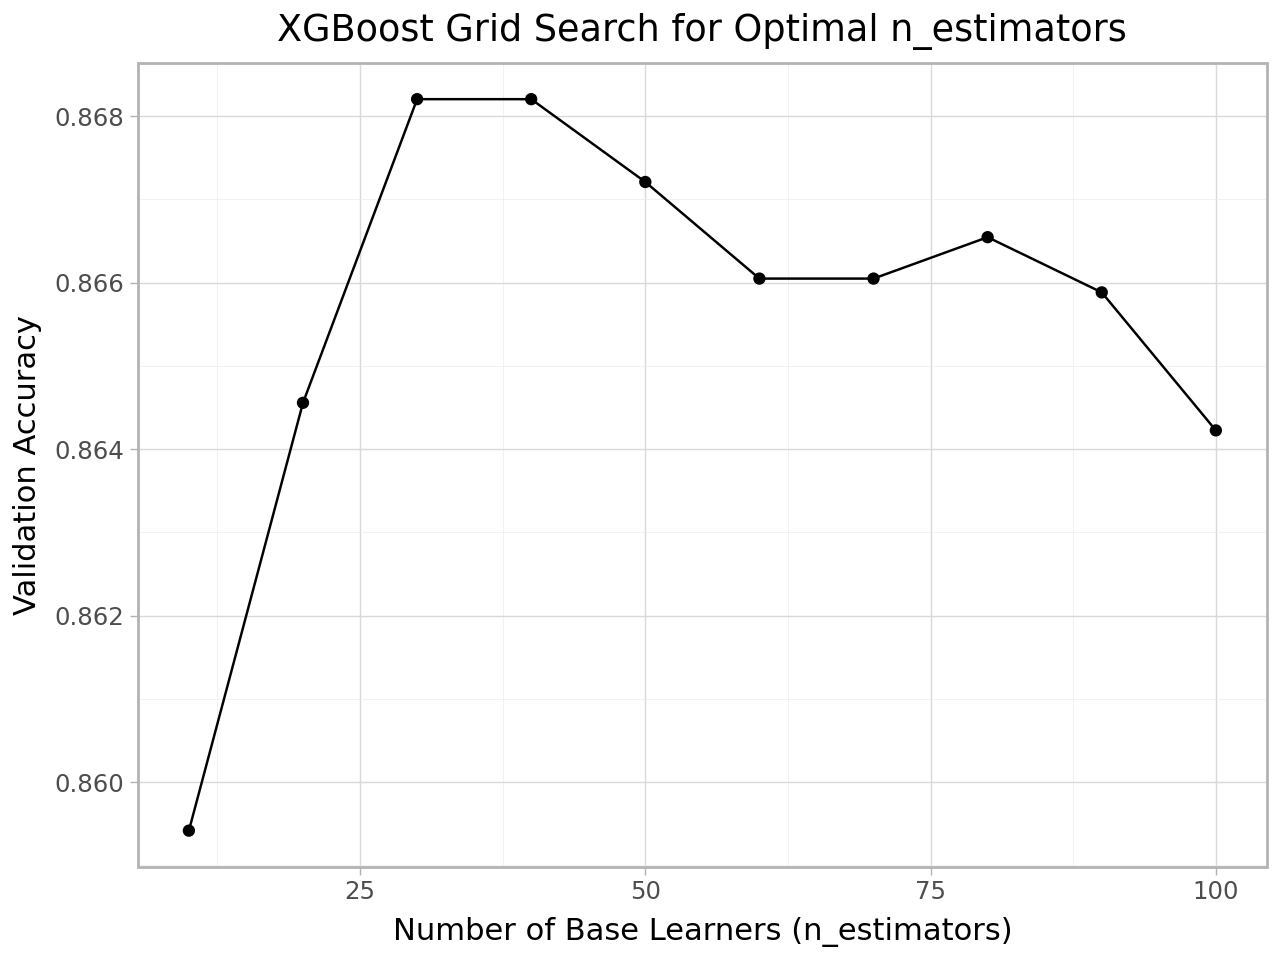

In [15]:
#Here we use 60% for training, 20% for validation, and 20% for test.
X_train, X_temp, y_train, y_temp = train_test_split(X_adult, y_adult,
                                                    test_size=0.4,
                                                    random_state=1,
                                                    stratify=y_adult)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5,
                                                random_state=1,
                                                stratify=y_temp)

#GRID SEARCH FOR BEST NUMBER OF BASE LEARNERS (M) FOR XGBOOST CLASSIFIER
M_grid = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
val_acc_list = []

print("XGBoost Grid Search:")
for M in M_grid:
    print(f"\nTraining XGBoost classifier with n_estimators = {M}")
    model = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=M,
                              learning_rate=0.3,
                              eval_metric='logloss',
                              random_state=1)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(acc)
    print(f"n_estimators = {M}, Validation Accuracy = {acc:.4f}")

results_df = pd.DataFrame({'M': M_grid, 'Validation_Accuracy': val_acc_list})
print("\nXGBoost Grid Search Results:")
print(results_df)
best_row = results_df.loc[results_df['Validation_Accuracy'].idxmax()]
best_M_xgb = int(best_row['M'])
best_acc_xgb = best_row['Validation_Accuracy']
print(f"\nBest n_estimators for XGBoost: {best_M_xgb} with Accuracy: {best_acc_xgb:.4f}")

#Plot the grid search results.
plot_grid = (ggplot(results_df, aes(x='M', y='Validation_Accuracy')) +
             geom_line() +
             geom_point() +
             labs(x="Number of Base Learners (n_estimators)", y="Validation Accuracy") +
             ggtitle("XGBoost Grid Search for Optimal n_estimators") +
             theme_light())
plot_grid

In [16]:
#TRAIN FINAL MODELS ON COMBINED TRAINING + VALIDATION DATA
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

#Final XGBoost Model
final_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=best_M_xgb,
                              learning_rate=0.3,
                              eval_metric='logloss',
                              random_state=1)
final_xgb.fit(X_train_val, y_train_val)
y_test_pred_xgb = final_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
y_test_proba_xgb = final_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"\nFinal XGBoost Test Accuracy: {acc_xgb:.4f}")
print(f"XGBoost Test AUC: {auc_xgb:.4f}")


Final XGBoost Test Accuracy: 0.8656
XGBoost Test AUC: 0.9244



Custom Model Grid Search:

Training Custom Gradient Boosting classifier with M = 10
M = 10, Validation Accuracy = 0.7512

Training Custom Gradient Boosting classifier with M = 20
M = 20, Validation Accuracy = 0.8145

Training Custom Gradient Boosting classifier with M = 30
M = 30, Validation Accuracy = 0.8175

Training Custom Gradient Boosting classifier with M = 40
M = 40, Validation Accuracy = 0.8218

Training Custom Gradient Boosting classifier with M = 50
M = 50, Validation Accuracy = 0.8239

Training Custom Gradient Boosting classifier with M = 60
M = 60, Validation Accuracy = 0.8263

Training Custom Gradient Boosting classifier with M = 70
M = 70, Validation Accuracy = 0.8276

Training Custom Gradient Boosting classifier with M = 80
M = 80, Validation Accuracy = 0.8273

Training Custom Gradient Boosting classifier with M = 90
M = 90, Validation Accuracy = 0.8284

Training Custom Gradient Boosting classifier with M = 100
M = 100, Validation Accuracy = 0.8292

Custom Model Grid Se

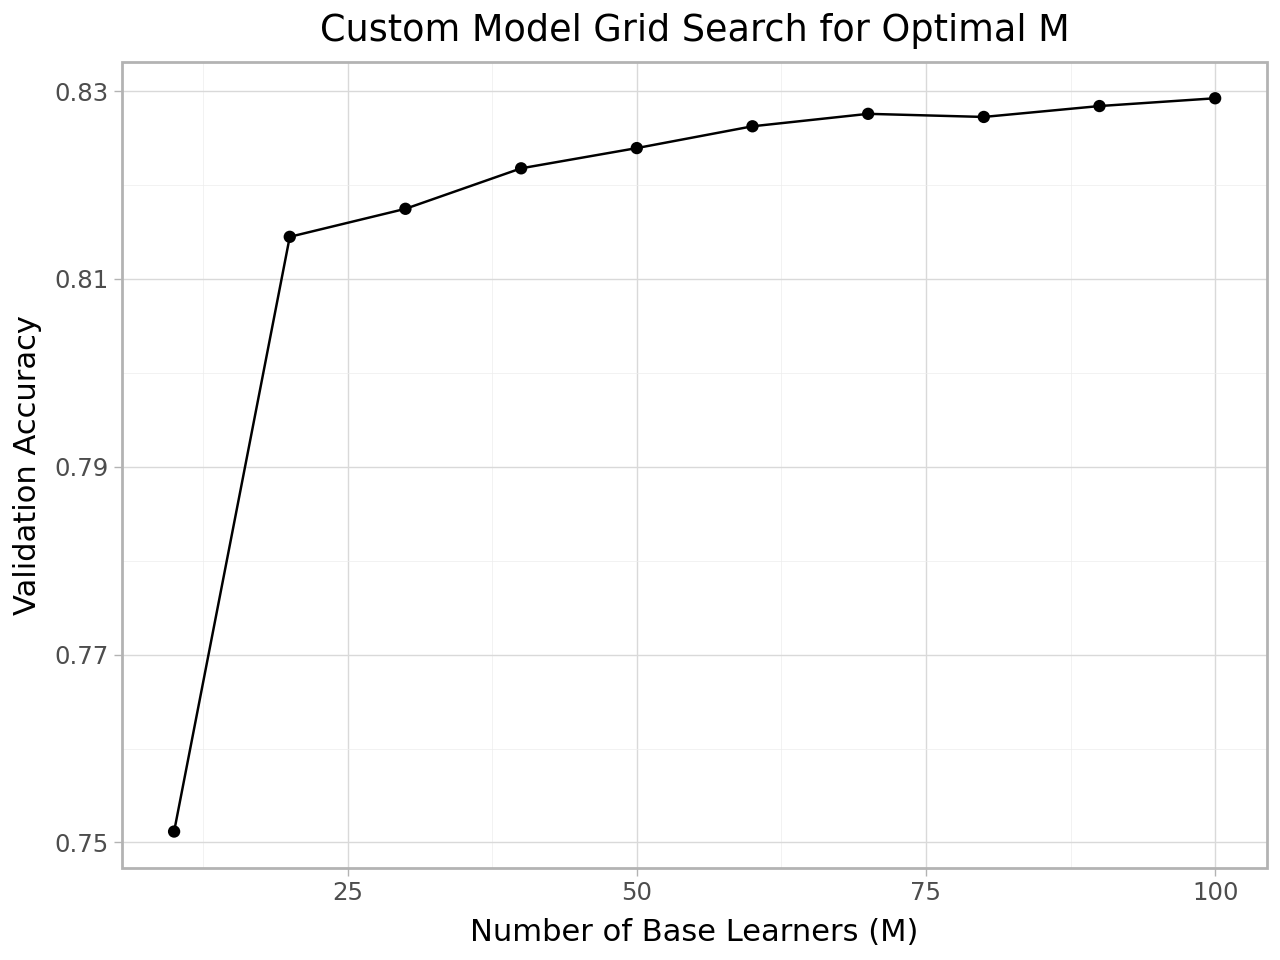

In [17]:
# --- Final Custom Gradient Boosting Model ---
custom_val_acc_list = []

print("\nCustom Model Grid Search:")
for M in M_grid:
    print(f"\nTraining Custom Gradient Boosting classifier with M = {M}")
    custom_model = GradientBoosting(is_classification=True, M=M, verbose=False)
    
    #Use numpy arrays as input.
    custom_model.fit(X_train.values, y_train.values)
    y_val_pred_custom = custom_model.predict(X_val.values)
    acc_custom = np.mean(y_val.values == y_val_pred_custom)
    custom_val_acc_list.append(acc_custom)
    print(f"M = {M}, Validation Accuracy = {acc_custom:.4f}")

results_custom_df = pd.DataFrame({'M': M_grid, 'Validation_Accuracy': custom_val_acc_list})
print("\nCustom Model Grid Search Results:")
print(results_custom_df)
best_row_custom = results_custom_df.loc[results_custom_df['Validation_Accuracy'].idxmax()]
best_M_custom = int(best_row_custom['M'])
best_acc_custom = best_row_custom['Validation_Accuracy']
print(f"\nBest M for Custom Model: {best_M_custom} with Accuracy: {best_acc_custom:.4f}")

plot_custom_grid = (ggplot(results_custom_df, aes(x='M', y='Validation_Accuracy')) +
                    geom_line() +
                    geom_point() +
                    labs(x="Number of Base Learners (M)", y="Validation Accuracy") +
                    ggtitle("Custom Model Grid Search for Optimal M") +
                    theme_light())
plot_custom_grid

Iteration 1/100, training error: 0.2489
Iteration 2/100, training error: 0.2489
Iteration 3/100, training error: 0.2489
Iteration 4/100, training error: 0.2489
Iteration 5/100, training error: 0.2489
Iteration 6/100, training error: 0.2489
Iteration 7/100, training error: 0.2489
Iteration 8/100, training error: 0.2489
Iteration 9/100, training error: 0.2489
Iteration 10/100, training error: 0.2489
Iteration 11/100, training error: 0.1842
Iteration 12/100, training error: 0.1842
Iteration 13/100, training error: 0.1842
Iteration 14/100, training error: 0.1842
Iteration 15/100, training error: 0.1842
Iteration 16/100, training error: 0.1842
Iteration 17/100, training error: 0.1842
Iteration 18/100, training error: 0.1842
Iteration 19/100, training error: 0.1842
Iteration 20/100, training error: 0.1842
Iteration 21/100, training error: 0.1842
Iteration 22/100, training error: 0.1837
Iteration 23/100, training error: 0.1835
Iteration 24/100, training error: 0.1834
Iteration 25/100, trainin

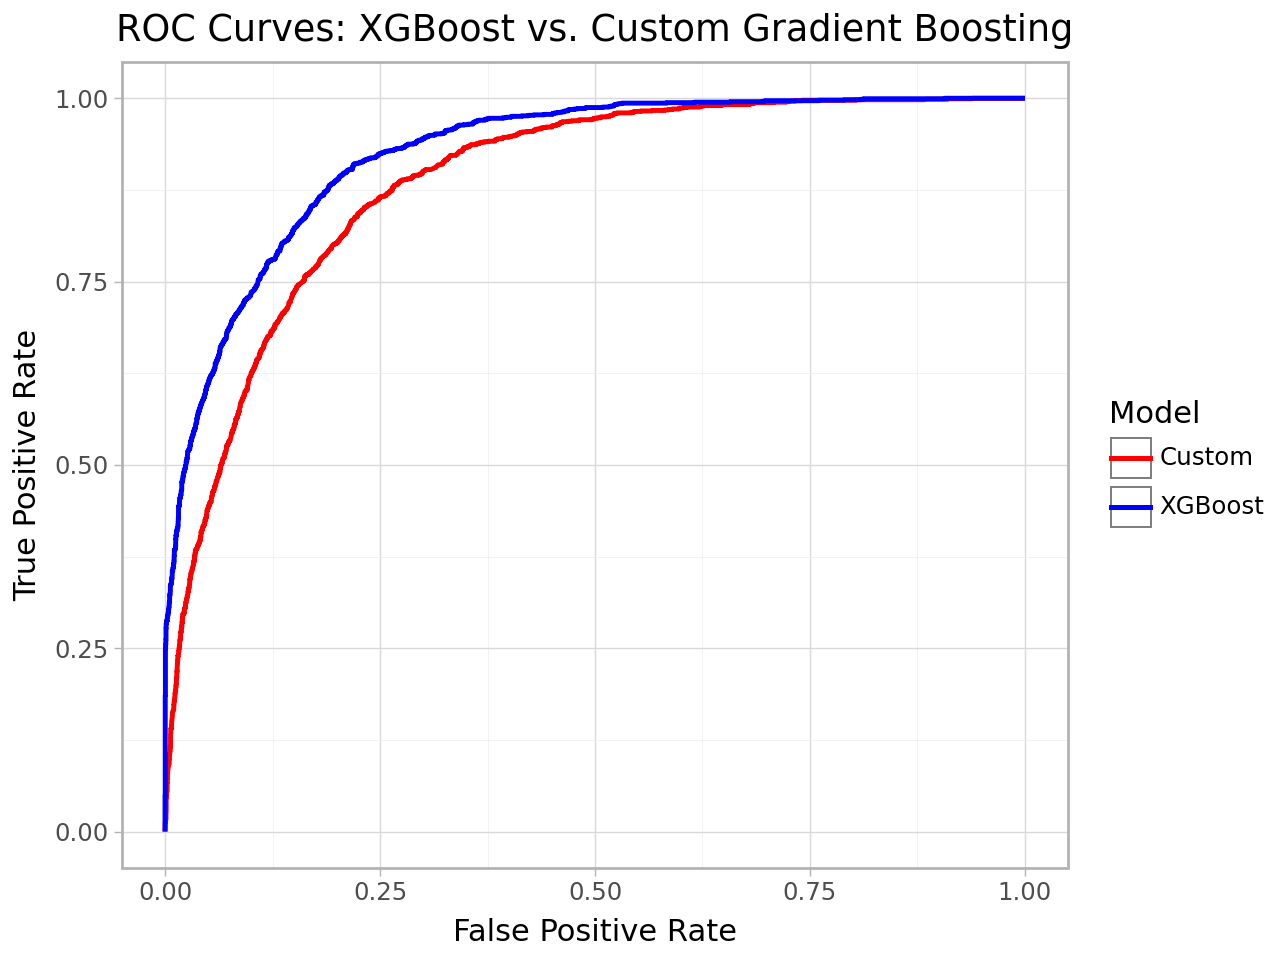

In [18]:
#Train the final custom model on combined training+validation data.
final_custom = GradientBoosting(is_classification=True, M=best_M_custom, verbose=True)
final_custom.fit(X_train_val.values, y_train_val.values)
y_test_pred_custom = final_custom.predict(X_test.values)
acc_custom_final = np.mean(y_test.values == y_test_pred_custom)
y_test_proba_custom = final_custom.predict_proba(X_test.values)
fpr_custom, tpr_custom, _ = roc_curve(y_test, y_test_proba_custom)
auc_custom = auc(fpr_custom, tpr_custom)
print(f"\nFinal Custom Model Test Accuracy: {acc_custom_final:.4f}")
print(f"Custom Model Test AUC: {auc_custom:.4f}")

#PERFORMANCE COMPARISON: PLOTTING ROC CURVES & BARCHARTS FOR ACCURACY AND AUC

#Prepare ROC data for XGBoost.
df_roc_xgb = pd.DataFrame({
    'FPR': fpr_xgb,
    'TPR': tpr_xgb,
    'Model': 'XGBoost'
})
#Prepare ROC data for the Custom model.
df_roc_custom = pd.DataFrame({
    'FPR': fpr_custom,
    'TPR': tpr_custom,
    'Model': 'Custom'
})
df_roc = pd.concat([df_roc_xgb, df_roc_custom])

roc_plot = (ggplot(df_roc, aes(x='FPR', y='TPR', color='Model')) +
            geom_line(size=1) +
            labs(x='False Positive Rate', y='True Positive Rate',
                 title='ROC Curves: XGBoost vs. Custom Gradient Boosting') +
            theme_light() +
            scale_color_manual(values={'XGBoost': 'blue', 'Custom': 'red'}))
roc_plot


Test Performance Comparison:
     Model  Test Accuracy  Test AUC
0  XGBoost       0.865573  0.924425
1   Custom       0.827946  0.885327


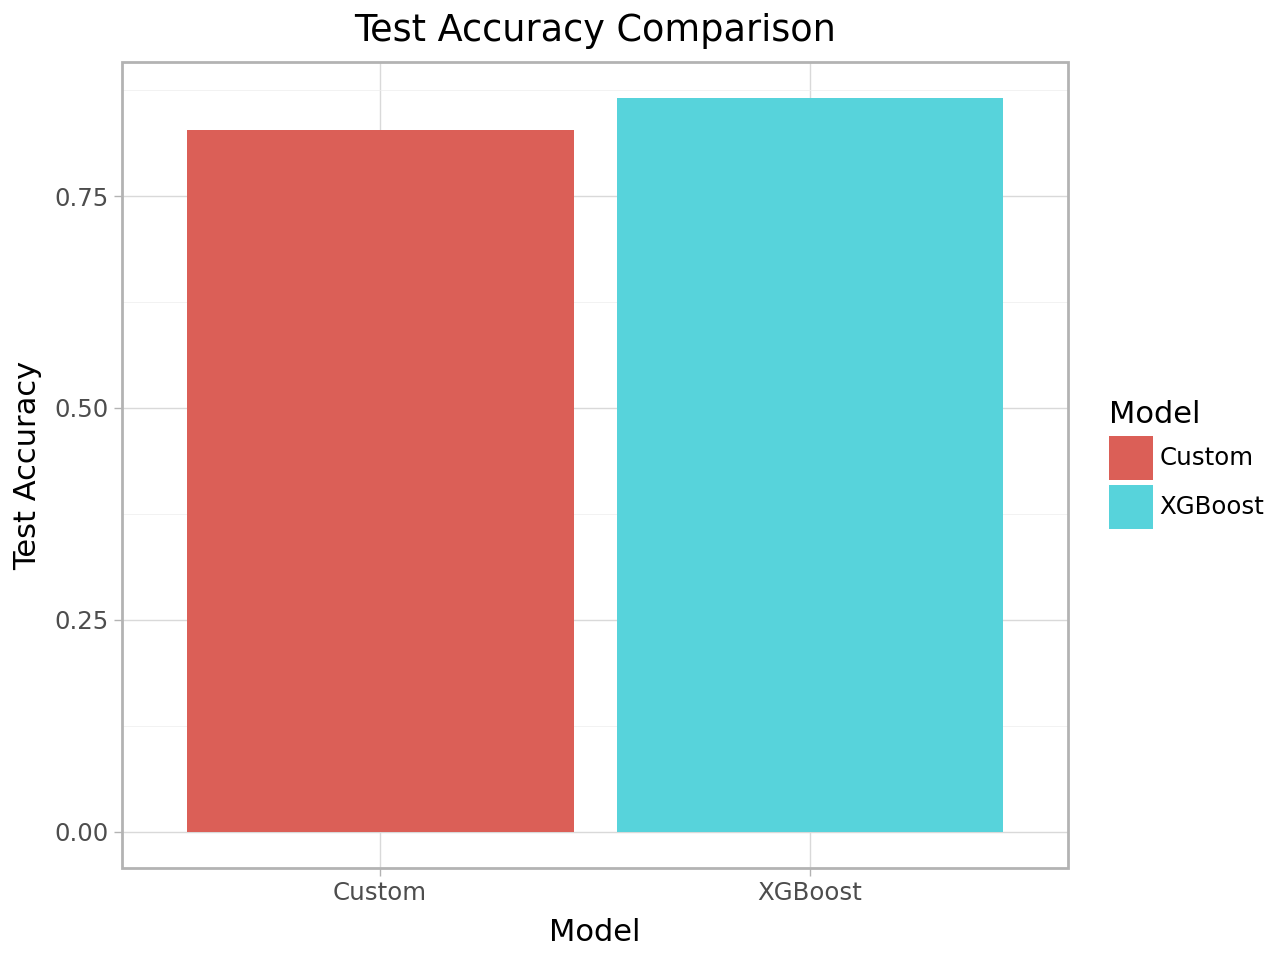

In [19]:
#Compare overall test performance with a bar chart.
results_compare = pd.DataFrame({
    'Model': ['XGBoost', 'Custom'],
    'Test Accuracy': [acc_xgb, acc_custom_final],
    'Test AUC': [auc_xgb, auc_custom]
})
print("\nTest Performance Comparison:")
print(results_compare)

accuracy_plot = (ggplot(results_compare, aes(x='Model', y='Test Accuracy', fill='Model')) +
                 geom_bar(stat='identity') +
                 labs(title='Test Accuracy Comparison') +
                 theme_light())
accuracy_plot

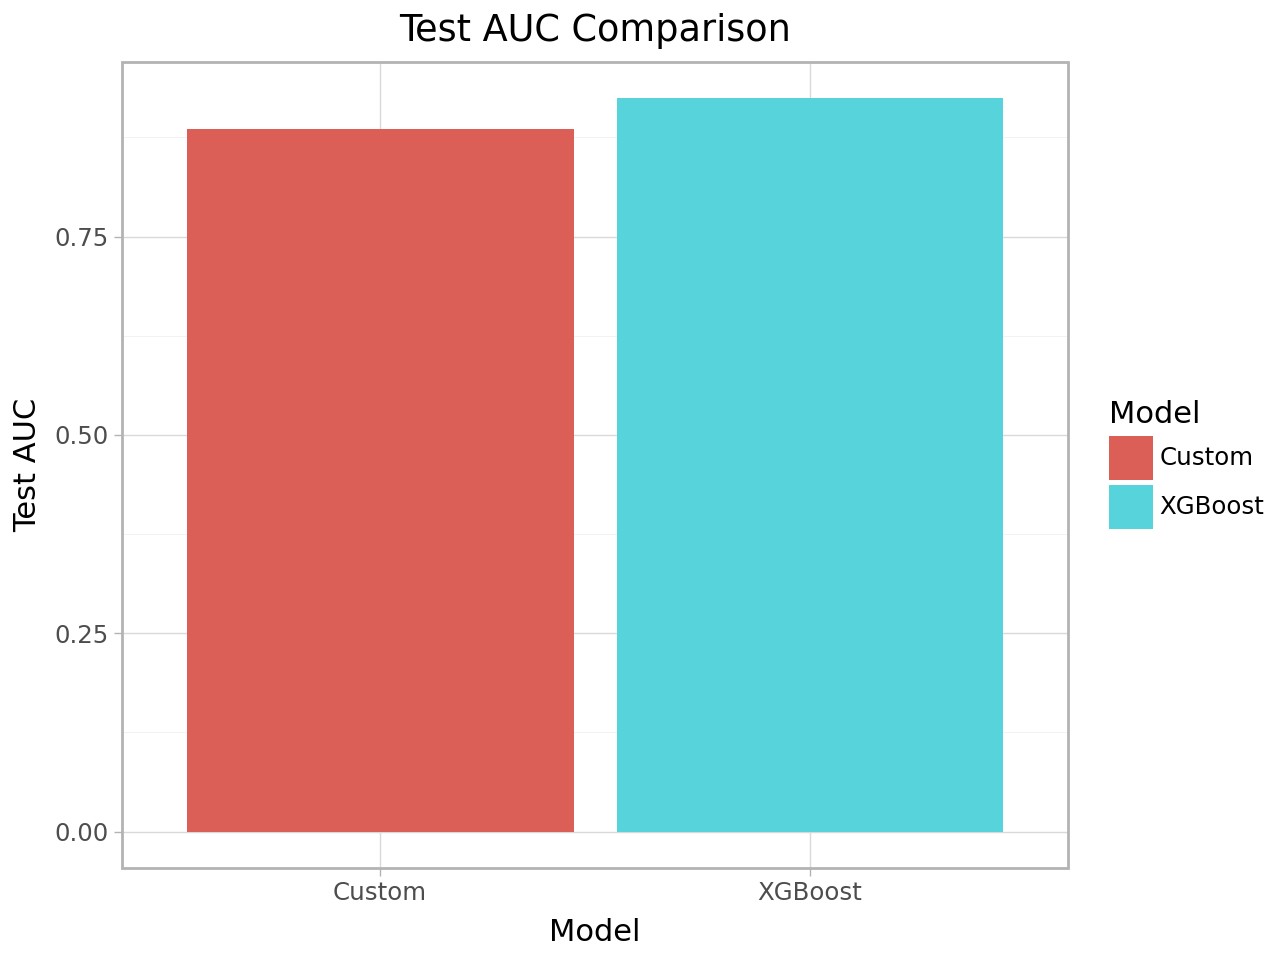

In [20]:
auc_plot = (ggplot(results_compare, aes(x='Model', y='Test AUC', fill='Model')) +
            geom_bar(stat='identity') +
            labs(title='Test AUC Comparison') +
            theme_light())
auc_plot